In [1]:
from typing import List
import numpy as np
import torch.cuda
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import copy
import nashpy as nash

from utils.logger import Logger
from utils.io_utils import save_code
from utils.utils import model_comparison,distribution_comparison, generate_outputs_from_distribution
from utils.plot import two_action_prob_plot

from algorithm_single_state import RewardModel, MaximumLikelihoodEstimator,PolicyGradientOptimizer,DirectPreferenceOptimizer, SelfPlayPreferenceOptimizer, SPPOClosedForm
from policy import UniformPolicyModel,PolicyModel,Ref_PolicyModel
from utils.collect_data import collect_preference_data, NonMonotonicScalarToVectorNN, check_data_consistency, check_cyclic_order

In [2]:
from datetime import datetime

np.random.seed(5)

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = f"./logs/test_{current_time}"
save_code(log_dir)

logger = Logger(log_dir)
writer = SummaryWriter(log_dir)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [3]:
state_dim = 1
actions = [-10,0,10]

### Collect data

In [4]:
torch.manual_seed(5)
feature_func = NonMonotonicScalarToVectorNN()
pref_dataset, p_list = collect_preference_data(actions,60,feature_func)

In [5]:
p_list

array([[0.5       , 0.75489888, 0.44118223],
       [0.24510112, 0.5       , 0.83795365],
       [0.55881777, 0.16204635, 0.5       ]])

In [5]:
pref_dataset

[Transition(state=array([0]), action_0=-10, action_1=0, pref=1, chosen_probs=0.24510111981513732),
 Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=10, action_1=0, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.44118222864585355),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=1, chosen_probs=0.5588177713541465),
 Transition(state=array([0]), action_0=10, action_1=-10, pref=1, chosen_probs=0.44118222864585355),
 Transition(state=

In [8]:
action_to_index = {-10: 0, 0: 1, 10: 2}

states = torch.cat([torch.tensor(x.state) for x in pref_dataset], dim=0)

positive_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_1] if x.pref == 1 else action_to_index[x.action_0]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

negative_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_0] if x.pref == 1 else action_to_index[x.action_1]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

print(f"states: {states}")
print(f"positive_actions: {positive_actions}")
print(f"negative_actions: {negative_actions}")

# check transition and consistency
print(f"check transition: {check_cyclic_order(p_list,actions)}")
print(f"check data consistency: {check_data_consistency(pref_dataset)}")

states: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
positive_actions: tensor([1, 0, 1, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 2, 2, 1,
        2, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1,
        0, 1, 2, 0, 1, 2, 1, 1, 1, 0, 1, 0])
negative_actions: tensor([0, 1, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 2, 1, 2, 0, 0, 1, 0, 0, 2,
        1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1, 0, 2, 2, 1, 2,
        1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 1])
check transition: (True, ('-10', '0', '10'))
check data consistency: 0.8


## Nash equilibrium

In [9]:
# compute nash equilibrium

A = np.array([
    [0.5, 0.1, 0.8],
    [0.9, 0.5, 0.1],
    [0.2, 0.9, 0.5]
])


game = nash.Game(p_list, -p_list)

#game = nash.Game(A, -A)
equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [0.51859606 0.09025695 0.39114699]


In [10]:
# We use action 0 and action 1 to plot the scatter plot
nash_point= [eq[0][0],eq[0][1]]
nash_point

[0.5185960617933865, 0.09025694564670378]

## 1 state 1 action

### RLHF

In [11]:
learned_reward_model = RewardModel(
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [12]:
mle_learner = MaximumLikelihoodEstimator(
    actions,
    learned_reward_model,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [13]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner.optimize(
    states, positive_actions, negative_actions, num_epochs=20
)

2024-11-30 16:15:37,996 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 0 loss: 0.6777 acc: 0.77
2024-11-30 16:15:38,004 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 2 loss: 0.6746 acc: 0.77
2024-11-30 16:15:38,010 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 4 loss: 0.6717 acc: 0.77
2024-11-30 16:15:38,018 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 6 loss: 0.6688 acc: 0.77
2024-11-30 16:15:38,025 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 8 loss: 0.6659 acc: 0.77
2024-11-30 16:15:38,032 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] Epoch 10 loss: 0.6632 acc: 0.77
2024-11-30 16:15:38,039 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:122] - INFO: [Reward] E

In [14]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)

ref_policy2 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.7,0.2,0.1]]),device).to(device)

ref_policy3 = Ref_PolicyModel(
    len(actions),torch.tensor([[1.0,0.0,0.0]]),device).to(device)

ref_policy4 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.1,0.3,0.6]]),device).to(device)

print(ref_policy(torch.tensor([[0.0]])))
print(ref_policy2(torch.tensor([[0.0]])))
print(ref_policy3(torch.tensor([[0.0]])))
print(ref_policy4(torch.tensor([[0.0]])))

tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([[0.7000, 0.2000, 0.1000]], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0')
tensor([[0.1000, 0.3000, 0.6000]], device='cuda:0')


In [15]:
states = torch.zeros(len(pref_dataset), 1, dtype=torch.float32).to(device) 
states.shape

torch.Size([60, 1])

In [16]:
# pg
policy = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [17]:
policy_optimizer = PolicyGradientOptimizer(
    policy=policy,
    reward_model=learned_reward_model,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    logger=logger,
    nash_point = nash_point
)

In [18]:
policy_optimizer.optimize(states=states, p_list=p_list, num_epochs=100)


/home/hanwen/policy_optimization/exp/utils/utils.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
2024-11-30 16:15:38,401 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:203] - INFO: [Policy] Epoch 0 loss: -0.2600 reward: 0.2600 ref_reward: 0.2734 improvement: -4.89%
2024-11-30 16:15:38,733 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:203] - INFO: [Policy] Epoch 2 loss: -0.2672 reward: 0.2672 ref_reward: 0.2734 improvement: -2.26%
2024-11-30 16:15:39,017 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:203] - INFO: [Policy] Epoch 4 loss: -0.2740 reward: 0.2740 ref_reward: 0.2734 improvement: 0.23%
2024-11-30 16:15:39,254 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:203]

KeyboardInterrupt: 

In [ ]:
state_0 = torch.tensor([0.0], dtype=torch.float32).to(device)
action_0 = torch.tensor([1,0,0], dtype=torch.float32).to(device)
action_1 = torch.tensor([0,0,1], dtype=torch.float32).to(device)
action_2 = torch.tensor([0,1,0], dtype=torch.float32).to(device)
print(learned_reward_model(state_0,action_0))
print(learned_reward_model(state_0,action_1))
print(learned_reward_model(state_0,action_2))

tensor([0.3088], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.1832], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.0883], device='cuda:0', grad_fn=<ViewBackward0>)


In [ ]:
# output the probabilities of each action from the learned policy
test_state = torch.tensor([[0.0]], dtype=torch.float32).to(device)  

with torch.no_grad():
    action_probs = policy(test_state)
    action_probs = action_probs.cpu().numpy()[0]  

actions = [-10, 0, 10]  
for action, prob in zip(actions, action_probs):
    print(f"P(action={action}) = {prob:.3f}")

# output the probabilities of each action from the reference policy
ref_probs = ref_policy(test_state).cpu().numpy()[0]
print("\nUniform policy probabilities:")
for action, prob in zip(actions, ref_probs):
    print(f"P(action={action}) = {prob:.3f}")

P(action=-10) = 0.990
P(action=0) = 0.003
P(action=10) = 0.007

Uniform policy probabilities:
P(action=-10) = 0.333
P(action=0) = 0.333
P(action=10) = 0.333


In [ ]:
# compare the learned policy with the reference policy
score = model_comparison(policy, ref_policy,p_list)
print(f"\nRLHF model and base model comparison score: {score:.3f}")


RLHF model and base model comparison score: 0.564


### DPO

In [ ]:
policy_dpo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [ ]:
dpo_optimizer_1 = DirectPreferenceOptimizer(
    policy=policy_dpo_1,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_2 = DirectPreferenceOptimizer(
    policy=policy_dpo_2,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_3 = DirectPreferenceOptimizer(
    policy=policy_dpo_3,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_4 = DirectPreferenceOptimizer(
    policy=policy_dpo_4,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

2024-11-28 14:45:25,697 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 0 loss: 0.6905 grad norm: 0.0221 
2024-11-28 14:45:27,104 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 5 loss: 0.6890 grad norm: 0.0066 
2024-11-28 14:45:28,540 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 10 loss: 0.6889 grad norm: 0.0059 
2024-11-28 14:45:29,981 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 15 loss: 0.6889 grad norm: 0.0054 
2024-11-28 14:45:31,415 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 20 loss: 0.6889 grad norm: 0.0027 
2024-11-28 14:45:32,850 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 25 loss: 0.6889 grad norm: 0.0030 
2024-11-28 14:45:34,284 - /home/hanwen/policy_optimiza

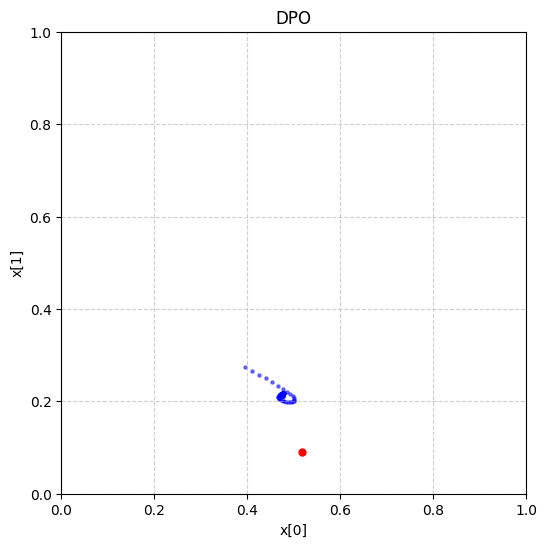

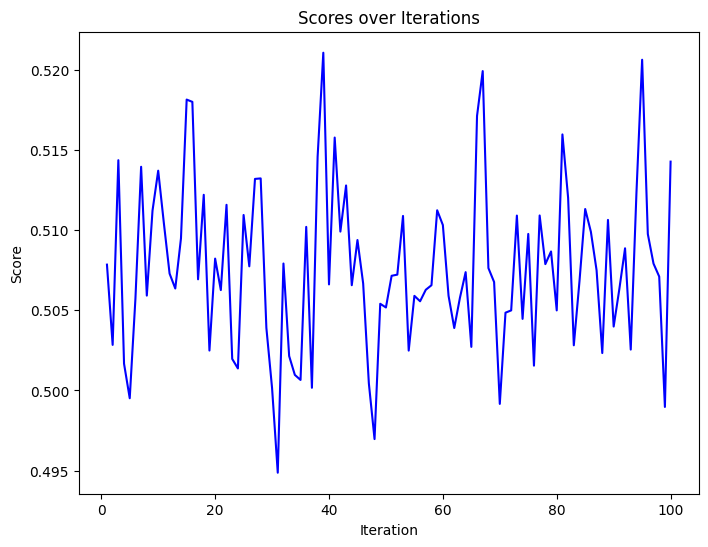

2024-11-28 14:45:54,447 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 0 loss: 0.7372 grad norm: 0.1044 
2024-11-28 14:45:55,667 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 5 loss: 0.7277 grad norm: 0.0937 
2024-11-28 14:45:56,877 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 10 loss: 0.7195 grad norm: 0.0903 
2024-11-28 14:45:58,256 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 15 loss: 0.7127 grad norm: 0.0897 
2024-11-28 14:45:59,511 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 20 loss: 0.7061 grad norm: 0.0868 
2024-11-28 14:46:00,860 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 25 loss: 0.7001 grad norm: 0.0771 
2024-11-28 14:46:02,053 - /home/hanwen/policy_optimiza

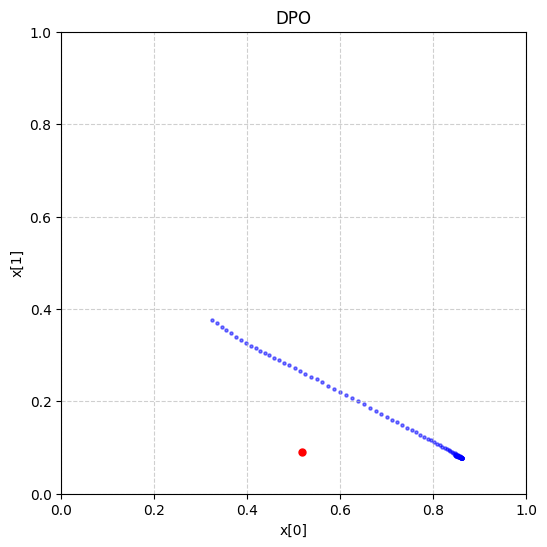

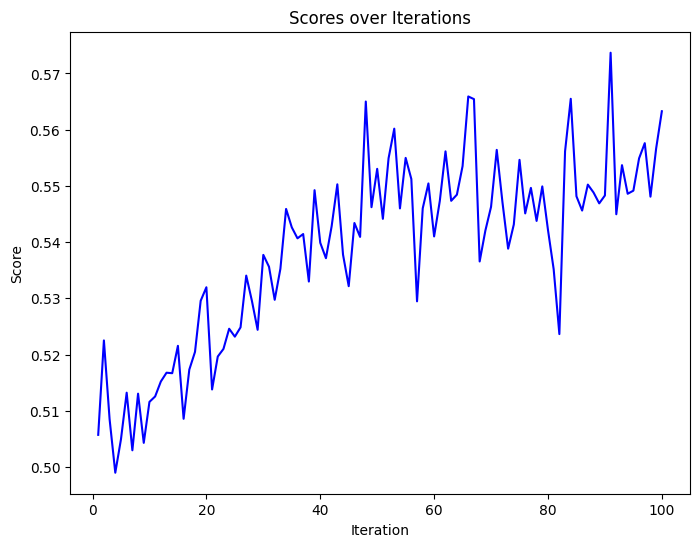

2024-11-28 14:46:21,974 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 0 loss: 0.7929 grad norm: 0.1668 
2024-11-28 14:46:23,356 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 5 loss: 0.7770 grad norm: 0.1675 
2024-11-28 14:46:24,736 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 10 loss: 0.7615 grad norm: 0.1702 
2024-11-28 14:46:26,041 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 15 loss: 0.7463 grad norm: 0.1660 
2024-11-28 14:46:27,445 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 20 loss: 0.7322 grad norm: 0.1508 
2024-11-28 14:46:28,724 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 25 loss: 0.7203 grad norm: 0.1263 
2024-11-28 14:46:30,091 - /home/hanwen/policy_optimiza

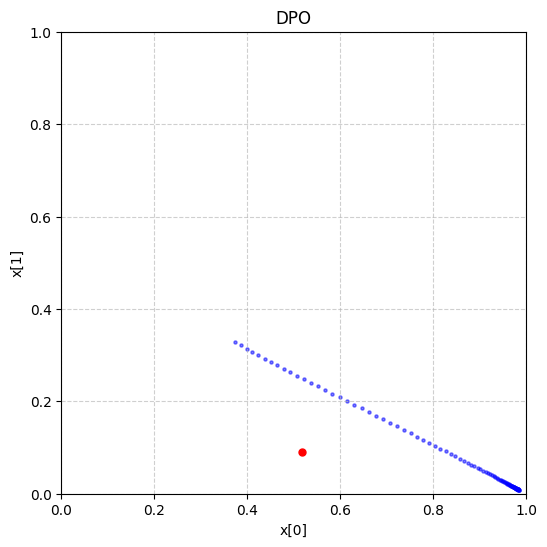

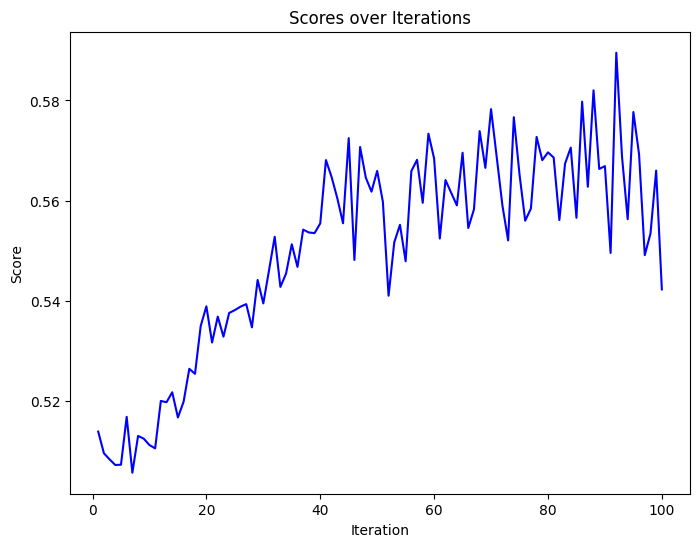

2024-11-28 14:46:58,398 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 0 loss: 0.7042 grad norm: 0.0591 
2024-11-28 14:47:00,527 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 5 loss: 0.6990 grad norm: 0.0443 
2024-11-28 14:47:02,885 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 10 loss: 0.6959 grad norm: 0.0372 
2024-11-28 14:47:04,999 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 15 loss: 0.6935 grad norm: 0.0332 
2024-11-28 14:47:07,078 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 20 loss: 0.6915 grad norm: 0.0281 
2024-11-28 14:47:09,396 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:331] - INFO: [Policy] Epoch: 25 loss: 0.6900 grad norm: 0.0207 
2024-11-28 14:47:11,452 - /home/hanwen/policy_optimiza

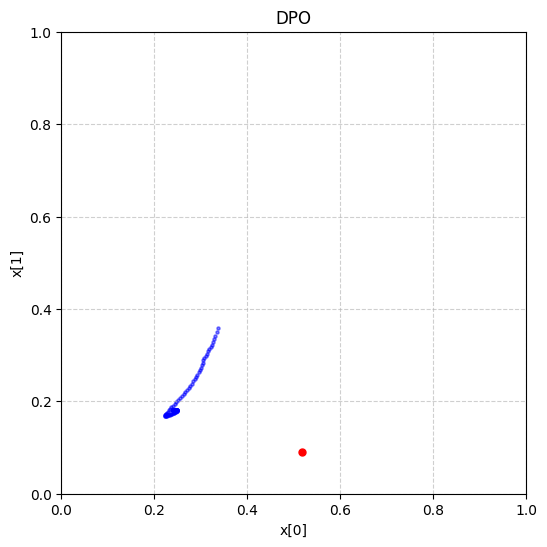

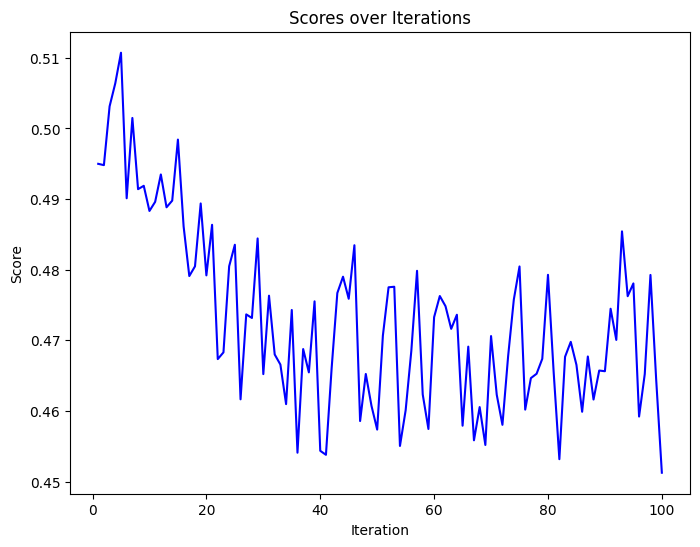

In [ ]:
dpo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.33,0.33,0.33]

dpo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.7,0.2,0.1]

dpo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [1.0,0.0,0.0]

dpo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    p_list=p_list,
    num_epochs=100
) # ref_policy = [0.1,0.3,0.6]

In [ ]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_dpo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score = model_comparison(policy_dpo_1, ref_policy,p_list)
print(f"\nDPO model and base model comparison score: {score:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_dpo_2, ref_policy2,p_list)
print(f"\nDPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_dpo_3, ref_policy3,p_list)
print(f"\nDPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_dpo_4, ref_policy4,p_list)
print(f"\nDPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.475
P(action=0) = 0.215
P(action=10) = 0.310

DPO model and base model comparison score: 0.518

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.846
P(action=0) = 0.084
P(action=10) = 0.070

DPO model and base model comparison score: 0.534

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.984
P(action=0) = 0.008
P(action=10) = 0.008

DPO model and base model comparison score: 0.499

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.240
P(action=0) = 0.181
P(action=10) = 0.578

DPO model and base model comparison score: 0.489


### SPPO

In [ ]:
policy_sppo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [ ]:
chosen_probs = torch.tensor([x.chosen_probs for x in pref_dataset], dtype=torch.float32).to(device)

In [ ]:
sppo_optimizer_1 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_1,
    ref_policy=ref_policy,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_2 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_2,
    ref_policy=ref_policy2,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_3 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_3,
    ref_policy=ref_policy3,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_4 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_4,
    ref_policy=ref_policy4,
    score_ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

In [ ]:
sppo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

sppo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

sppo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

sppo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    p_list=p_list,
    num_epochs=300
)

2024-11-28 14:47:44,282 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:455] - INFO: [Policy] Epoch: 0 loss: 0.0029 grad norm: 0.0769 
2024-11-28 14:47:46,403 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:455] - INFO: [Policy] Epoch: 5 loss: 0.0000 grad norm: 0.0040 
2024-11-28 14:47:48,417 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:455] - INFO: [Policy] Epoch: 10 loss: 0.0003 grad norm: 0.0141 
2024-11-28 14:47:50,345 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:455] - INFO: [Policy] Epoch: 15 loss: 0.0003 grad norm: 0.0133 
2024-11-28 14:47:52,478 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:455] - INFO: [Policy] Epoch: 20 loss: 0.0000 grad norm: 0.0011 
2024-11-28 14:47:54,459 - /home/hanwen/policy_optimization/exp/algorithm_single_state.py[line:455] - INFO: [Policy] Epoch: 25 loss: 0.0001 grad norm: 0.0074 
2024-11-28 14:47:56,394 - /home/hanwen/policy_optimiza

KeyboardInterrupt: 

In [ ]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_sppo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
score = model_comparison(policy_sppo_1, ref_policy,p_list)
print(f"\nSPPO model and base model comparison score: {score:.3f}")


with torch.no_grad():
    action_probs = policy_sppo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_sppo_2, ref_policy2,p_list)
print(f"\nSPPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_sppo_3, ref_policy3,p_list)
print(f"\nSPPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_sppo_4, ref_policy4,p_list)
print(f"\nSPPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.353
P(action=0) = 0.251
P(action=10) = 0.395

SPPO model and base model comparison score: 0.499

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.453
P(action=0) = 0.269
P(action=10) = 0.278

SPPO model and base model comparison score: 0.485

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.371
P(action=0) = 0.319
P(action=10) = 0.309

SPPO model and base model comparison score: 0.444

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.228
P(action=0) = 0.323
P(action=10) = 0.449

SPPO model and base model comparison score: 0.523


### SPPO Closed-form solution

In [ ]:
sppo_closed_form_1 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_2 = SPPOClosedForm( 
    actions,                      
    score_ref_model = ref_policy,             
    ref_policy=ref_policy2,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_3 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy3,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_4 = SPPOClosedForm(
    actions,
    score_ref_model = ref_policy,
    ref_policy=ref_policy4,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

2024-11-26 15:37:18,974 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 0: ref_distribution = tensor([0.3333, 0.3333, 0.3333], device='cuda:0'), new_distribution = tensor([0.3336, 0.3334, 0.3330], device='cuda:0')


2024-11-26 15:37:19,040 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 1: ref_distribution = tensor([0.3336, 0.3334, 0.3330], device='cuda:0'), new_distribution = tensor([0.3338, 0.3335, 0.3327], device='cuda:0')
2024-11-26 15:37:19,095 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 2: ref_distribution = tensor([0.3338, 0.3335, 0.3327], device='cuda:0'), new_distribution = tensor([0.3340, 0.3336, 0.3324], device='cuda:0')
2024-11-26 15:37:19,149 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 3: ref_distribution = tensor([0.3340, 0.3336, 0.3324], device='cuda:0'), new_distribution = tensor([0.3342, 0.3337, 0.3321], device='cuda:0')
2024-11-26 15:37:19,203 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 4: ref_distribution = tensor([0.3342, 0.3337, 0.3321], device='cuda:0'), new_distribution = tensor([0.3344, 0.3338, 0.3318], device='cuda:0')
2024-11-26 15:37

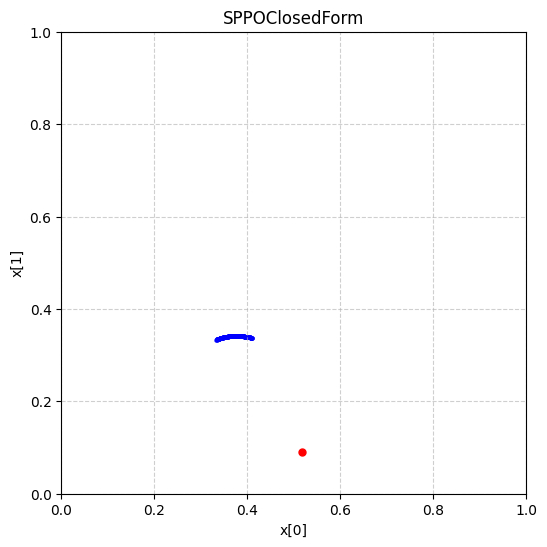

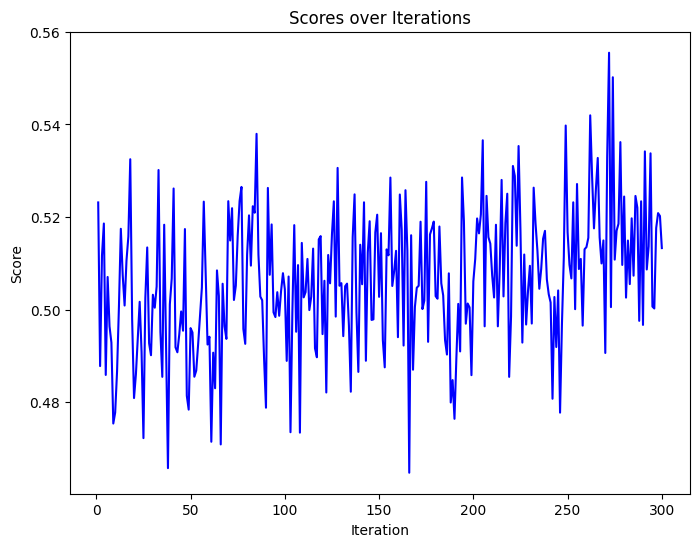

2024-11-26 15:37:34,234 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 0: ref_distribution = tensor([0.7000, 0.2000, 0.1000], device='cuda:0'), new_distribution = tensor([0.7003, 0.1997, 0.1000], device='cuda:0')
2024-11-26 15:37:34,280 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 1: ref_distribution = tensor([0.7003, 0.1997, 0.1000], device='cuda:0'), new_distribution = tensor([0.7006, 0.1994, 0.0999], device='cuda:0')
2024-11-26 15:37:34,328 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 2: ref_distribution = tensor([0.7006, 0.1994, 0.0999], device='cuda:0'), new_distribution = tensor([0.7009, 0.1991, 0.0999], device='cuda:0')
2024-11-26 15:37:34,374 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 3: ref_distribution = tensor([0.7009, 0.1991, 0.0999], device='cuda:0'), new_distribution = tensor([0.7013, 0.1988, 0.0999], device='cuda:0')
2024-11-26 15:37

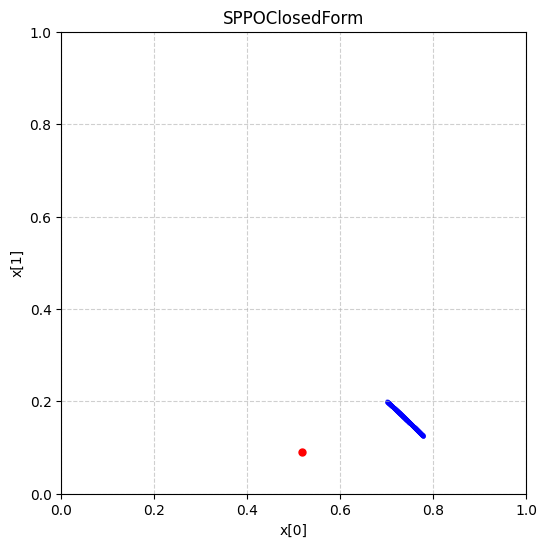

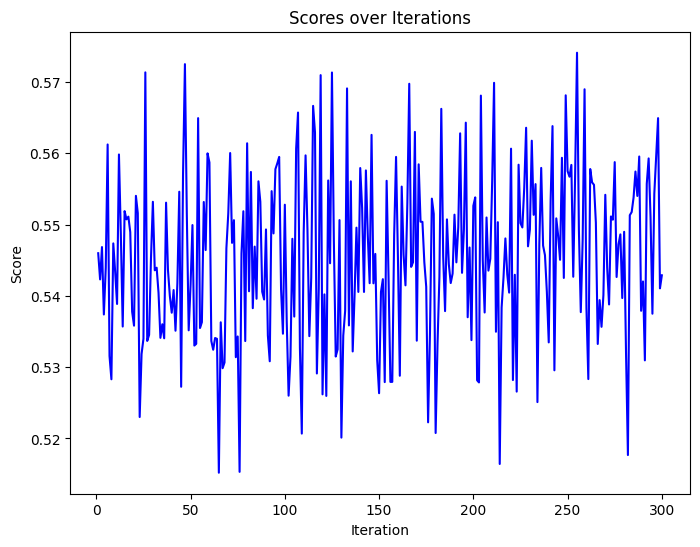

2024-11-26 15:37:49,951 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 0: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-26 15:37:49,997 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 1: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-26 15:37:50,043 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 2: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-26 15:37:50,088 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 3: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-26 15:37:50,134 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 4: ref_d

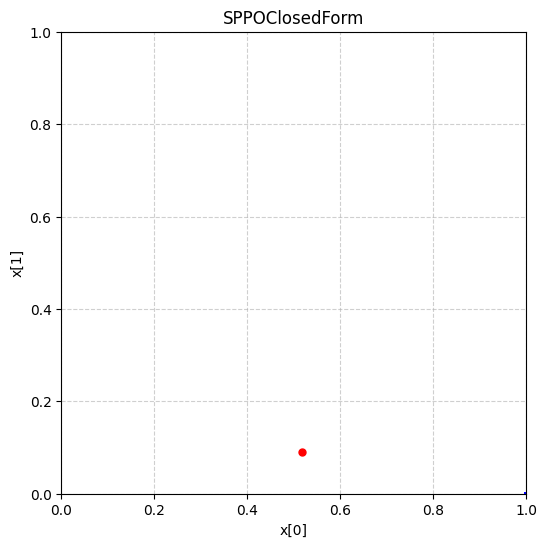

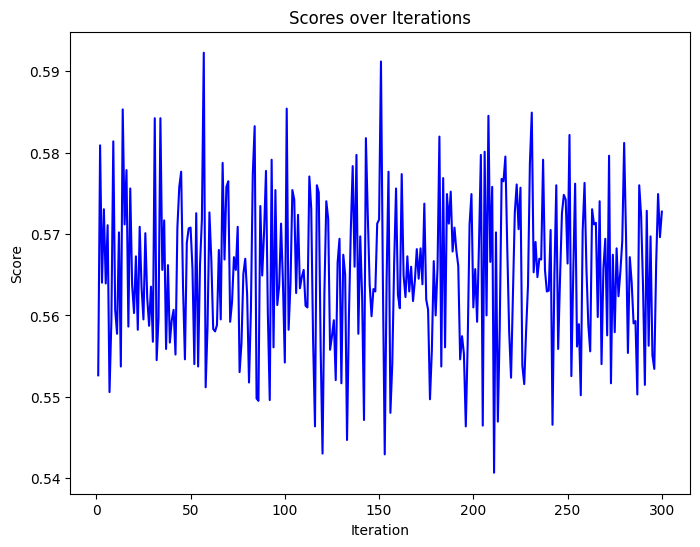

2024-11-26 15:38:04,381 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 0: ref_distribution = tensor([0.1000, 0.3000, 0.6000], device='cuda:0'), new_distribution = tensor([0.1000, 0.3005, 0.5994], device='cuda:0')
2024-11-26 15:38:04,428 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 1: ref_distribution = tensor([0.1000, 0.3005, 0.5994], device='cuda:0'), new_distribution = tensor([0.1001, 0.3011, 0.5989], device='cuda:0')
2024-11-26 15:38:04,474 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 2: ref_distribution = tensor([0.1001, 0.3011, 0.5989], device='cuda:0'), new_distribution = tensor([0.1001, 0.3016, 0.5983], device='cuda:0')
2024-11-26 15:38:04,520 - /home/hanwen/policy_optimization/exp/algorithm.py[line:538] - INFO: Iteration 3: ref_distribution = tensor([0.1001, 0.3016, 0.5983], device='cuda:0'), new_distribution = tensor([0.1002, 0.3021, 0.5977], device='cuda:0')
2024-11-26 15:38

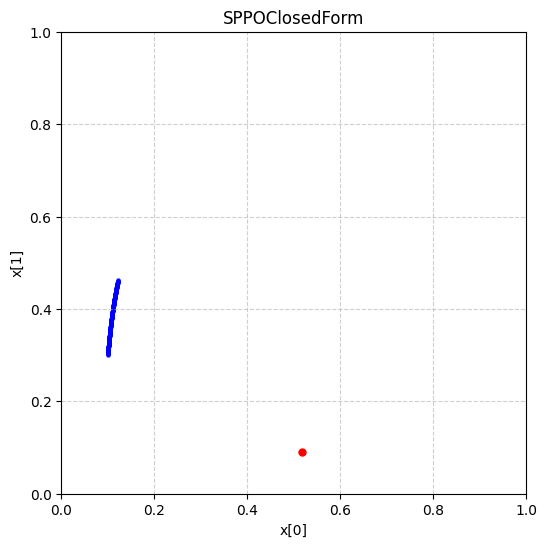

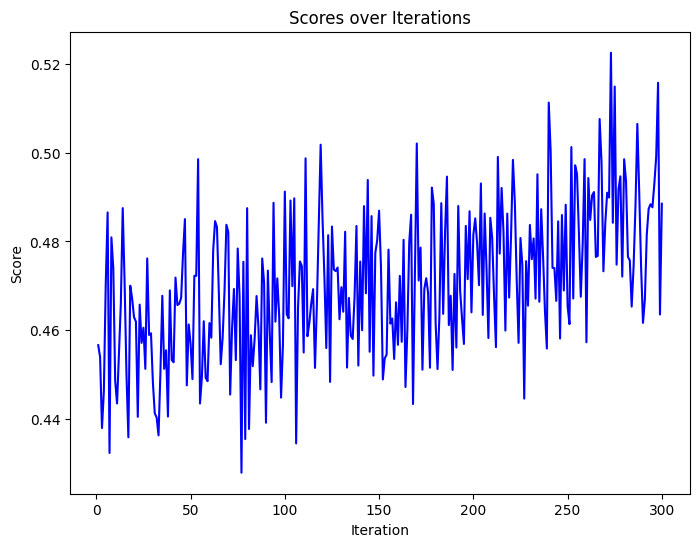

In [ ]:
sppo_distribution_1 = sppo_closed_form_1.optimize(
    p_list=p_list,
    num_iters=300
)   

sppo_distribution2 = sppo_closed_form_2.optimize(
    p_list=p_list,
    num_iters=300
)

sppo_distribution3 = sppo_closed_form_3.optimize(
    p_list=p_list,
    num_iters=300
)

sppo_distribution4 = sppo_closed_form_4.optimize(
    p_list=p_list,
    num_iters=300
)

## 3 states 6 actions

In [ ]:
state_num = 3
action_num = 18

### Collect data

In [ ]:
import numpy as np

def get_state_p_list(action_num, transitivity_rate, seed=42):
    np.random.seed(seed)
    
    actions = np.arange(action_num)
    p_list = np.zeros((action_num, action_num))
    np.fill_diagonal(p_list, 0.5)  # Self-preference is 0.5
    
    # Select actions in cycle
    cycle_num = int(action_num * transitivity_rate)
    in_cycle_actions = np.random.choice(actions, cycle_num, replace=False)
    
    # Actions not in cycle
    non_cycle_actions = [a for a in actions if a not in in_cycle_actions]
    
    # 1. Form a cycle
    for i in range(len(in_cycle_actions)):
        current = in_cycle_actions[i]
        next_action = in_cycle_actions[(i + 1) % len(in_cycle_actions)]  # Loop back to start
        p_list[current][next_action] = np.round(np.random.uniform(0.7, 1), 2)
        p_list[next_action][current] = np.round(1 - p_list[current][next_action], 2)
    
    # 2. Assign preferences for non-adjacent pairs in cycle
    for i in range(len(in_cycle_actions)):
        for j in range(i + 2, len(in_cycle_actions)):
            a, b = in_cycle_actions[i], in_cycle_actions[j]
            if p_list[a][b] == 0:
                p_list[a][b] = np.round(np.random.uniform(0.7, 1), 2)
                p_list[b][a] = np.round(1 - p_list[a][b], 2)
    
    # 3. Assign preferences within non-cycle actions (linear transitivity)
    for i in range(len(non_cycle_actions)):
        for j in range(i + 1, len(non_cycle_actions)):
            a1, a2 = non_cycle_actions[i], non_cycle_actions[j]
            p_list[a1][a2] = np.round(np.random.uniform(0.7, 1), 2)
            p_list[a2][a1] = np.round(1 - p_list[a1][a2], 2)
    
    # 4. Assign preferences between cycle and non-cycle actions
    for cycle_a in in_cycle_actions:
        for non_cycle_a in non_cycle_actions:
            # In cycle actions are always better than non-cycle actions
            p_list[cycle_a][non_cycle_a] = np.round(np.random.uniform(0.7, 1), 2)
            p_list[non_cycle_a][cycle_a] = np.round(1 - p_list[cycle_a][non_cycle_a], 2)
    

    return p_list, in_cycle_actions



# generate p_list with different transitivity rates
# p_list, in_cycle_actions = get_state_p_list(action_num=6, transitivity_rate=0, seed=42)
# print("\nCycle actions:", in_cycle_actions)
# print(f"p_list(transitivity rate = {0}):")
# print(p_list)

# p_list, in_cycle_actions = get_state_p_list(action_num=6, transitivity_rate=0.5, seed=42)
# print("\nCycle actions:", in_cycle_actions)
# print(f"p_list(transitivity rate = {0.5}):")
# print(p_list)

# p_list, in_cycle_actions = get_state_p_list(action_num=6, transitivity_rate=1, seed=42)
# print("\nCycle actions:", in_cycle_actions)
# print(f"p_list(transitivity rate = {1}):")
# print(p_list)

In [ ]:
def get_p_list(state_num, action_num, transitivity_rate, master_seed=42):
    rng = np.random.default_rng(master_seed)
    
    p_list = np.zeros((state_num, action_num, action_num))
    for i in range(state_num):
        seed = rng.integers(0, 1e6)
        p_list[i], in_cycle_actions = get_state_p_list(action_num, transitivity_rate, seed=seed)
        # print(f"\nState {i} cycle actions:", in_cycle_actions)
    return p_list

multi_state_p_list_0 = get_p_list(state_num=3, action_num=6, transitivity_rate=0, master_seed=42)
multi_state_p_list_50 = get_p_list(state_num=3, action_num=6, transitivity_rate=0.5, master_seed=42)
multi_state_p_list_100 = get_p_list(state_num=3, action_num=6, transitivity_rate=1, master_seed=42)
# print("\nGenerated p_list:")
# print(multi_state_p_list_50)
    

In [ ]:
import collections


Transition = collections.namedtuple(
    "Transition", ["state", "action_0", "action_1", "pref", "chosen_probs"]
)

def collect_preference_data_multi_state(
    state_num: int,
    action_num: int,
    sample_size: int,
    p_list: np.ndarray,
) -> List[Transition]:
    
    
    pref_dataset = []
     
    for i in range(state_num):
        cur_state = i
        actions = np.arange(action_num) 
            
        for j in range(sample_size):
            idx_one, idx_two = np.random.choice(len(actions), 2, replace=False)
            action_one = actions[idx_one]
            action_two = actions[idx_two]
        
            bernoulli_param = p_list[i][idx_one][idx_two]
        
            if np.random.random() < bernoulli_param:  
                transition = Transition(
                    cur_state, action_one, action_two, 0, p_list[i][idx_one][idx_two]
                )
            else:
                transition = Transition(
                    cur_state, action_two, action_one, 1, p_list[i][idx_two][idx_one]
                )
            pref_dataset.append(transition)

           
    return pref_dataset,p_list

In [ ]:
pref_dataset_0, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_0)
pref_dataset_50, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_50)
pref_dataset_100, _ = collect_preference_data_multi_state(state_num=3, action_num=6, sample_size=100, p_list=multi_state_p_list_100)
len(pref_dataset_0), len(pref_dataset_50), len(pref_dataset_100)

(300, 300, 300)

In [ ]:
pref_dataset_0

[Transition(state=0, action_0=0, action_1=2, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=3, pref=1, chosen_probs=0.07),
 Transition(state=0, action_0=3, action_1=4, pref=0, chosen_probs=0.93),
 Transition(state=0, action_0=3, action_1=5, pref=1, chosen_probs=0.95),
 Transition(state=0, action_0=3, action_1=4, pref=1, chosen_probs=0.93),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=3, action_1=2, pref=1, chosen_probs=0.22),
 Transition(state=0, action_0=0, action_1=3, pref=0, chosen_probs=0.96),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=1, action_1=3, pref=1, chosen_probs=0.76),
 Transition(state=0, action_0=0, action_1=2, pref=0, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=5, pref=0

In [ ]:
def check_data_consistency(pref_dataset):
    consistent = 0
    total = len(pref_dataset)
    
    for t in pref_dataset:
      
        if (t.chosen_probs > 0.5):
            consistent += 1
    
    return consistent / total

In [ ]:
check_data_consistency(pref_dataset_0), check_data_consistency(pref_dataset_50), check_data_consistency(pref_dataset_100)

(0.88, 0.8466666666666667, 0.8733333333333333)

In [ ]:
pref_dataset_0

[Transition(state=0, action_0=0, action_1=2, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=3, pref=1, chosen_probs=0.07),
 Transition(state=0, action_0=3, action_1=4, pref=0, chosen_probs=0.93),
 Transition(state=0, action_0=3, action_1=5, pref=1, chosen_probs=0.95),
 Transition(state=0, action_0=3, action_1=4, pref=1, chosen_probs=0.93),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=3, action_1=2, pref=1, chosen_probs=0.22),
 Transition(state=0, action_0=0, action_1=3, pref=0, chosen_probs=0.96),
 Transition(state=0, action_0=2, action_1=3, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=1, action_1=3, pref=1, chosen_probs=0.76),
 Transition(state=0, action_0=0, action_1=2, pref=0, chosen_probs=0.78),
 Transition(state=0, action_0=2, action_1=5, pref=1, chosen_probs=0.78),
 Transition(state=0, action_0=4, action_1=5, pref=0

In [ ]:
multi_states_0 = torch.cat([torch.tensor([x.state]) for x in pref_dataset_0], dim=0).to(torch.float32).to(device)
multi_states_idx_0 = [x.state for x in pref_dataset_0]

In [ ]:
positive_actions_multi_states_0 = torch.cat(
    [torch.tensor(x.action_1 if x.pref == 1 else x.action_0).unsqueeze(0) for x in pref_dataset_0],
    dim=0
).to(device)

negative_actions_multi_states_0 = torch.cat(
    [torch.tensor(x.action_0 if x.pref == 1 else x.action_1).unsqueeze(0) for x in pref_dataset_0],
    dim=0
).to(device)

### RLHF

In [ ]:
from utils.plot import plot_scores
from torch.nn import functional as F


class RewardModel_MultiState(nn.Module):
   def __init__(
       self,
       state_dim,
       state_num,
       action_dim,  
       hidden_dim: int = 128,
       num_layers: int = 2,
       device: str = "cpu",
   ):
       super().__init__()
       self.device = torch.device(device)
       self.action_dim = action_dim
       self.state_num = state_num
       
       self.state_feature_extractor = nn.Sequential(
           nn.Linear(state_dim, hidden_dim),
           nn.Tanh(),
           *[nn.Linear(hidden_dim, hidden_dim), nn.Tanh()] * (num_layers-1)
       ).to(self.device)
       

       self.action_feature_extractors = nn.ModuleList([
           nn.Sequential(
               nn.Linear(self.action_dim, hidden_dim),
               nn.Tanh(),
               *[nn.Linear(hidden_dim, hidden_dim), nn.Tanh()] * (num_layers-1)
           ).to(self.device)
           for _ in range(self.state_num)
       ]) # shape: [state_num, action_dim]

       self.predict_layer = nn.Linear(hidden_dim * 2, 1).to(self.device)

   def forward(self, state_idx: int, state: torch.tensor, action: torch.tensor) -> torch.tensor:
       hs = self.state_feature_extractor(state)
       ha = self.action_feature_extractors[state_idx](action)
       h = torch.cat([hs, ha], dim=1)
       return self.predict_layer(h)

In [ ]:
from utils.plot import plot_scores
from torch.nn import functional as F

        
class MaximumLikelihoodEstimator:
    def __init__(
        self,
        action_num: int,
        reward_model: nn.Module,
        learning_rate: float = 1e-3,
        weight_decay: float = 0.0,
        batch_size: int = 64,
        logger: Logger = None,
    ):
        self.action_num = action_num
        self.reward_model = reward_model
        self.batch_size = batch_size
        self.logger = logger

        self.optimizer = torch.optim.AdamW(
            self.reward_model.parameters(), lr=learning_rate, weight_decay=weight_decay
        )

    def optimize_one_epoch(self, states, states_idx, positive_actions, negative_actions):
        total_loss = 0.0
        total_acc = 0.0

        k = 0
        for i in range(0, len(states), self.batch_size):
            self.optimizer.zero_grad()

            _states = states[i : i + self.batch_size]
            _states_idx = states_idx[i : i + self.batch_size]
            
            _positive_actions = positive_actions[i : i + self.batch_size]
            _negative_actions = negative_actions[i : i + self.batch_size]

            _positive_actions = F.one_hot(
                _positive_actions, num_classes=self.action_num
            )
            _negative_actions = F.one_hot(
                _negative_actions, num_classes=self.action_num
            )
            
         
            _states = _states.unsqueeze(1) if _states.dim() == 1 else _states
            

            positive_rews = self.reward_model(_states_idx,_states,  _positive_actions)
            negative_rews = self.reward_model( _states_idx,_states, _negative_actions)

            loss = -torch.log(torch.sigmoid(positive_rews - negative_rews)).mean()
            loss.backward()
            self.optimizer.step()

            acc = (positive_rews > negative_rews).float().mean()

            total_loss += loss.item()
            total_acc += acc.item()
            k += 1

        return total_loss / k, total_acc / k

    def optimize(self, states,states_idx, positive_actions, negative_actions, num_epochs):
        for epoch in range(num_epochs):
            loss, acc = self.optimize_one_epoch(
                states,states_idx, positive_actions, negative_actions
            )
            if self.logger:
                if epoch % 2 == 0:
                    self.logger.info(
                        f"[Reward] Epoch {epoch} loss: {loss:.4f} acc: {acc:.2f}"
                    )

class PolicyGradientOptimizer:
    def __init__(
        self,
        policy: nn.Module,
        reward_model: nn.Module,
        ref_policy: nn.Module,  
        score_ref_policy: nn.Module,
        learning_rate: float = 1e-3,
        batch_size: int = 64,
        logger: Logger = None,
        nash_point: List[float] = None,
    ):
        self.policy = policy
        self.reward_model = reward_model
        self.ref_policy = ref_policy
        self.score_ref_policy = score_ref_policy
        
        self.batch_size = batch_size
        self.logger = logger
        self.nash_point = nash_point
        
        self.optimizer = torch.optim.AdamW(
            self.policy.parameters(), lr=learning_rate
        )

    def optimize_one_epoch(self, states):
        total_loss = 0.0
        k = 0
        for i in range(0, len(states), self.batch_size):
            self.optimizer.zero_grad()
            
            _states = states[i : i + self.batch_size]
           
            distributions = self.policy(_states)
            ref_distributions = self.ref_policy(_states)        
            
            rewards = self.reward_model(_states, distributions)
            ref_rewards = self.reward_model(_states, ref_distributions)
            
            
            loss = -torch.sum(distributions * rewards, dim=-1).mean()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            k += 1
            
            # record prob of choosing action 0 and action 1
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            test_state = torch.tensor([[0.0]], dtype=torch.float32).to(device) 
            with torch.no_grad():
                action_probs = self.policy(test_state)
                action_probs = action_probs.cpu().numpy()[0] 
            action_0_prob = action_probs[0]
            action_1_prob = action_probs[1]
            
        return total_loss / k, rewards.mean().item(), ref_rewards.mean().item(), action_0_prob, action_1_prob

    def optimize(
        self,
        states: torch.tensor,
        p_list:List[List[float]],
        num_epochs=100):
        
        action_0_probs = []
        action_1_probs = []
        scores = []
        for epoch in range(num_epochs):
            loss, reward, ref_reward, action_0_prob, action_1_prob  = self.optimize_one_epoch(states)
            action_0_probs.append(action_0_prob)
            action_1_probs.append(action_1_prob)
            
            score = model_comparison(self.policy, self.score_ref_policy, p_list)
            scores.append(score)
            
            if epoch % 2 == 0:
                if self.logger:
                    self.logger.info(
                        f"[Policy] Epoch {epoch} "
                        f"loss: {loss:.4f} "
                        f"reward: {reward:.4f} "
                        f"ref_reward: {ref_reward:.4f} "
                        f"improvement: {(reward-ref_reward)/abs(ref_reward):.2%}"
                    )
        two_action_prob_plot(action_0_probs, action_1_probs,self.nash_point,'RLHF')
        plot_scores(scores, num_epochs)

In [ ]:
learned_reward_model_multi_states = RewardModel_MultiState(
    state_dim=1,
    state_num=3,
    action_dim=6,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [ ]:
mle_learner_multi_states = MaximumLikelihoodEstimator(
    action_num,
    learned_reward_model_multi_states,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [ ]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner_multi_states.optimize(
    multi_states_0,multi_states_idx_0, positive_actions_multi_states_0, negative_actions_multi_states_0, num_epochs=20
)

TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
ref_policy_multi_states = UniformPolicyModel(
    state_num,
    action_num=action_num,
    device=device
).to(device)

### DPO

### SPPO

### SPPO closed-form solution

## Summary

In [ ]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    
    print("\n ##### Learned policy probabilities of RLHF: #####")
    action_probs = policy(test_state)
    print("\nLearned policy probabilities(RLHF):")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score = model_comparison(policy, ref_policy,p_list)
    print(f"\nRLHF model and base model comparison score: {score:.3f}")


 ##### Learned policy probabilities of RLHF: #####

Learned policy probabilities(RLHF):
P(action=-10) = 0.987
P(action=0) = 0.007
P(action=10) = 0.006

RLHF model and base model comparison score: 0.554


In [ ]:
print("\n ##### Learned policy probabilities of DPO: #####")
with torch.no_grad():
    
    action_probs_dpo1 = policy_dpo_1(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_dpo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo1 = model_comparison(policy_dpo_1, ref_policy,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo1:.3f}")
    
    
    action_probs_dpo2 = policy_dpo_2(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_dpo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo2 = model_comparison(policy_dpo_2, ref_policy2,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo2:.3f}")
    
    
    action_probs_dpo3 = policy_dpo_3(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_dpo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    score_dpo3 = model_comparison(policy_dpo_3, ref_policy3,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo3:.3f}")
    
    
    action_probs_dpo4 = policy_dpo_4(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_dpo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_dpo4 = model_comparison(policy_dpo_4, ref_policy4,p_list)
    print(f"\nDPO model and base model comparison score: {score_dpo4:.3f}")


 ##### Learned policy probabilities of DPO: #####

Learned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.476
P(action=0) = 0.214
P(action=10) = 0.310



DPO model and base model comparison score: 0.508

Learned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.840
P(action=0) = 0.082
P(action=10) = 0.079

DPO model and base model comparison score: 0.527

Learned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 0.982
P(action=0) = 0.008
P(action=10) = 0.010

DPO model and base model comparison score: 0.497

Learned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.241
P(action=0) = 0.181
P(action=10) = 0.578

DPO model and base model comparison score: 0.494


In [ ]:
print("\n ##### Learned policy probabilities of SPPO: #####")
with torch.no_grad():
    action_probs_sppo1 = policy_sppo_1(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = model_comparison(policy_sppo_1, ref_policy,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = policy_sppo_2(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = model_comparison(policy_sppo_2, ref_policy2,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = policy_sppo_3(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = model_comparison(policy_sppo_3, ref_policy3,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = policy_sppo_4(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = model_comparison(policy_sppo_4, ref_policy4,feature_func)
    print(f"\nSPPO model and base model comparison score: {score_sppo4:.3f}")


 ##### Learned policy probabilities of SPPO: #####

Learned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.304
P(action=0) = 0.309
P(action=10) = 0.387


TypeError: 'NonMonotonicScalarToVectorNN' object is not subscriptable

In [ ]:
print("\n ##### Learned policy probabilities of SPPO-ClosedForm: #####")
with torch.no_grad():
    action_probs_sppo1 = sppo_distribution_1
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo1 = distribution_comparison(sppo_distribution_1, ref_policy,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo1:.3f}")
    
    
    action_probs_sppo2 = sppo_distribution2
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo2 = distribution_comparison(sppo_distribution2, ref_policy2,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo2:.3f}")
    
    
    action_probs_sppo3 = sppo_distribution3
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo3 = distribution_comparison(sppo_distribution3, ref_policy3,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo3:.3f}")
    
    
    action_probs_sppo4 = sppo_distribution4
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    score_sppo4 = distribution_comparison(sppo_distribution4, ref_policy4,feature_func)
    print(f"\nSPPO-ClosedForm model and base model comparison score: {score_sppo4:.3f}")
        


 ##### Learned policy probabilities of SPPO-ClosedForm: #####

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.410
P(action=0) = 0.337
P(action=10) = 0.252

SPPO-ClosedForm model and base model comparison score: 0.012

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.778
P(action=0) = 0.125
P(action=10) = 0.097

SPPO-ClosedForm model and base model comparison score: 0.011

Learned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 1.000
P(action=0) = 0.000
P(action=10) = 0.000

SPPO-ClosedForm model and base model comparison score: 0.000

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.122
P(action=0) = 0.462
P(action=10) = 0.415

SPPO-ClosedForm model and base model comparison score: 0.010
